# User Behaviour in Food Store

This document will be an analysis of behaviour in user of an app that sells food.
There will also be A/A/B testing for a change of font in the app.

## Loading and Preparing Data

### Loading Libraries and Data

In [32]:
import pandas as pd
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt
from plotly import graph_objects as go
from scipy import stats as st
import numpy as np
import math as mth
import warnings
warnings.filterwarnings("ignore")

In [33]:
try:
    exp = pd.read_csv('C:/Csvs/logs_exp_us.csv',
                      sep = '\s+', header = 0,
                      names = ['event', 'user_id', 'event_time', 'group'],
                      dtype = {'group':'category'}, 
                      )
except:
    exp = pd.read_csv('/datasets/logs_exp_us.csv',
                      sep = '\s+', header = 0,
                      names = ['event', 'user_id', 'event_time', 'group'],
                      dtype = {'group':'category'}, 
                      )

### Pre-Processing

In [34]:
exp['event_time'] = pd.to_datetime(exp['event_time'], unit = 's')

In [35]:
exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event       244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_time  244126 non-null  datetime64[ns]
 3   group       244126 non-null  category      
dtypes: category(1), datetime64[ns](1), int64(1), object(1)
memory usage: 5.8+ MB


Renamed columns, adapted data types, no missing values.

In [36]:
#checking for duplicated rows
exp.duplicated().sum()

413

In [37]:
exp.drop_duplicates(inplace = True)
exp.duplicated().sum()

0

Duplicated rows have been found and removed.

Checking to see if all users appear in just one group- can't have a user appearing on multiple and ruining the experiment.

In [38]:
exp.groupby('user_id').agg({'group' : 'nunique'}).reset_index()['group'].value_counts()

1    7551
Name: group, dtype: int64

All users appear in just one experiment group.

In [39]:
exp['event_date'] = pd.to_datetime(exp['event_time'].dt.date)
exp

,event,user_id,event_time,group,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


Added column for date of events, to enable grouping later.

## Studying Data

Taking a closer look at the dataset we are working with.

In [40]:
print('Number of events in log:', exp['event'].count())
print('Number of users in log:', exp['user_id'].nunique())

Number of events in log: 243713
Number of users in log: 7551


In [41]:
events_mean = exp.groupby('user_id').agg({'event' : 'count'}).reset_index()['event'].mean()
events_median = exp.groupby('user_id').agg({'event' : 'count'}).reset_index()['event'].median()

print('Mean number of events per user:', events_mean)
print('Median number of events per user:', events_median)

Mean number of events per user: 32.27559263673685
Median number of events per user: 20.0


In [42]:
earliest_event = exp['event_date'].min()
latest_event = exp['event_date'].max()
print('Earliest event date in log:', earliest_event)
print('Latest event date in log:', latest_event)

Earliest event date in log: 2019-07-25 00:00:00
Latest event date in log: 2019-08-07 00:00:00


All events occured in the span of two weeks. Lets look at how the events are distributed across this period- 

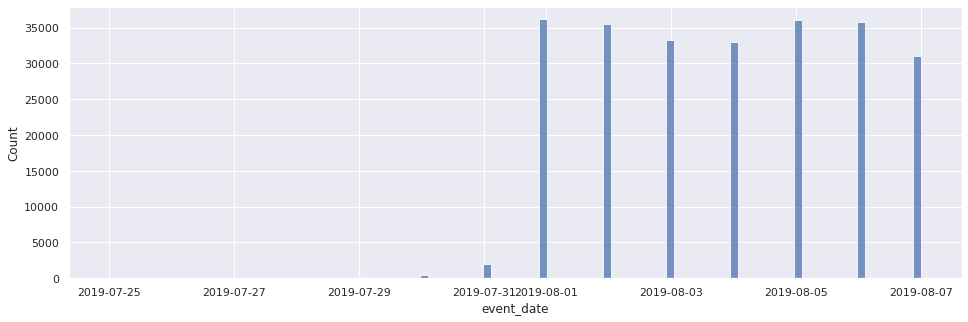

In [43]:
sns.set(rc = {'figure.figsize':(16,5)})
sns.histplot(data = exp, x = exp['event_date'])
plt.show()

We can see we mostly have events from the second week of our time span.
The small number of entries before the beggining of August could be there for technical reasons, and it may skew our data.
Only entries from the 1st of August on will be taken on.

This means our span will be 1 full week.

In [44]:
exp_filt = exp.query('event_date >= "2019-08-01"')

In [45]:
print('Number of events lost:', exp['event'].count() - exp_filt['event'].count())
print('Number of users lost:',exp['user_id'].nunique() - exp_filt['user_id'].nunique()) 

Number of events lost: 2826
Number of users lost: 17


Not a lot of data has been lost.

In [46]:
exp_filt['group'].value_counts()

248    84563
246    79302
247    77022
Name: group, dtype: int64

We have users from each groups, and a similar sample sizes from each of them.

## Event Funnel

First lets take a look at what kind of events we have in our logs-

In [47]:
exp_filt['event'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event, dtype: int64

This simply shows us how many times every event occured in the span of our week.
Lets narrow it to show the number of users that experienced each event.

In [48]:
users_per_event = (exp_filt.groupby('event')
                   .agg({'user_id' : 'nunique'})
                   .sort_values(by = 'user_id', ascending = False)
                   .reset_index()
                  )
users_per_event.columns = ['event', 'user_count']
users_per_event['proportion'] = users_per_event['user_count'] / exp_filt['user_id'].nunique()
users_per_event

,event,user_count,proportion
0,MainScreenAppear,7419,0.984736
1,OffersScreenAppear,4593,0.609636
2,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737
4,Tutorial,840,0.111495


The order of operations appears so: Main screen -> Offers -> Cart -> Payment. 
Judging by the user count and proportions, the Tutorial screen is optional, and so not many users enter it.

Seeing as the Tutorial step is optional, it will be omitted:

In [49]:
exp_filt = exp_filt.query('event != "Tutorial"')

In [50]:
users_steps = users_per_event.query('event != "Tutorial"')
users_steps['share'] = users_steps['user_count'].div(users_steps['user_count'].shift())
users_steps

,event,user_count,proportion,share
0,MainScreenAppear,7419,0.984736,NaN
1,OffersScreenAppear,4593,0.609636,0.619086
2,CartScreenAppear,3734,0.495620,0.812976
3,PaymentScreenSuccessful,3539,0.469737,0.947777


In [51]:
fig = go.Figure(go.Funnel(
    y = users_steps['event'],
    x = users_steps['user_count'],
    textposition = 'inside',
    textinfo = 'value+percent initial+percent previous'))

fig.show()

We see we lose the most users between the Main screen and The offer screen.

We can also see 48% of users go through the entire path, from entering the app to payment.

## A/A/B results

Here we shall discuss the results for the attempt at changing the app's font.

First, lets remind ourselves of our group sizes-

In [52]:
group_sizes = exp_filt.groupby('group').agg({'user_id' : 'nunique'}).reset_index()
group_sizes.columns = ['group','group_size']
group_sizes

,group,group_size
0,246,2483
1,247,2512
2,248,2535


To better percieve the changes the switched font may have created, first we shall compare out two control groups, to see how much change is expected between any two seperate groups- if we find a statisticaly significant difference between them, that same condition cannot be compared to group B (248) with any certainty as to the results.

Narrowing scope to the events that is the most common- entering the main page.

In [53]:
def aa_diff_find(event):
    AA_event_users = exp_filt.query('event == @event').groupby('group').agg({'user_id':'nunique'}).reset_index()
    AA_event_users = AA_event_users.merge(group_sizes)
    AA_event_users['share'] = AA_event_users['user_id'] / AA_event_users['group_size']
    diffaa = 1 - (AA_event_users.iloc[1,3] / AA_event_users.iloc[0,3])
    return diffaa

In [54]:
aa_diff_find('MainScreenAppear')

0.0010548550630443687

There is a 0.1% difference in shares between control groups, well within a reasonable margin for error.
With the function built, same comparison can be made for the other events:

In [55]:
print('Difference in shares for Offers screen:', aa_diff_find('OffersScreenAppear'))
print('Difference in shares for Cart screen:', aa_diff_find('CartScreenAppear'))
print('Difference in shares for Payment Successful screen:', aa_diff_find('PaymentScreenSuccessful'))

Difference in shares for Offers screen: 0.025647062711178337
Difference in shares for Cart screen: 0.03340615912498379
Difference in shares for Payment Successful screen: 0.04614052547770697


All differences are under 5%- again under a reasonable margin. The differences are supposed to be getting bigger from step to step (except Tutorial), as users have a mendatory series of events, so the difference "carries over" to the next step. 

Now a different function will be built to carry on a z-proportions test for the coversion between each pair of steps, for any 2 given groups.

Testing hypothesis:

    H0: Proportions between steps are equal
    H1: Proportions between steps aren't equal

In [56]:
#Setting alpha value outside of function, so it can be changed at any time:
alpha = 0.0042

def z_tester_id(group1 , group2):
    #Counting trials & successes for group1:
    users_per_event_group1 = (exp_filt.query('group == @group1').groupby('event')
                   .agg({'user_id' : 'nunique'})
                   .sort_values(by = 'user_id', ascending = False)
                   .reset_index()
                  )
    trials_group1_main_offers = users_per_event_group1.iloc[0,1]
    successes_group1_main_offers = users_per_event_group1.iloc[1,1]
    
    trials_group1_offers_cart = users_per_event_group1.iloc[1,1]
    successes_group1_offers_cart = users_per_event_group1.iloc[2,1]
    
    trials_group1_cart_payment = users_per_event_group1.iloc[2,1]
    successes_group1_cart_payment = users_per_event_group1.iloc[3,1]

    #Counting trials & successes for group2:
    users_per_event_group2 = (exp_filt.query('group == @group2').groupby('event')
                   .agg({'user_id' : 'nunique'})
                   .sort_values(by = 'user_id', ascending = False)
                   .reset_index()
                  )
    trials_group2_main_offers = users_per_event_group2.iloc[0,1]
    successes_group2_main_offers = users_per_event_group2.iloc[1,1]
    
    trials_group2_offers_cart = users_per_event_group2.iloc[1,1]
    successes_group2_offers_cart = users_per_event_group2.iloc[2,1]
    
    trials_group2_cart_payment = users_per_event_group2.iloc[2,1]
    successes_group2_cart_payment = users_per_event_group2.iloc[3,1]
    
    #Testing hypothesis for every step's conversion:

    p1 = successes_group1_main_offers / trials_group1_main_offers
    p2 = successes_group2_main_offers / trials_group2_main_offers
    p_combined = (successes_group1_main_offers + successes_group2_main_offers) / (trials_group1_main_offers + trials_group2_main_offers)
    difference = p1-p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_group1_main_offers + 1/trials_group2_main_offers))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-value: ', p_value)
    if (p_value < alpha):
        print("Rejecting the null hypothesis: there is a significant difference between the proportions in conversion between Main and Offer steps")
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider the proportions in conversion between Main and Offer steps different")
    
    p1 = successes_group1_offers_cart / trials_group1_offers_cart
    p2 = successes_group2_offers_cart / trials_group2_offers_cart
    p_combined = (successes_group1_offers_cart + successes_group2_offers_cart) / (trials_group1_offers_cart + trials_group2_offers_cart)
    difference = p1-p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_group1_offers_cart + 1/trials_group2_offers_cart))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Rejecting the null hypothesis: there is a significant difference between the proportions in conversion between Offer and Cart steps")
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider the proportions in conversion between Offer and Cart steps different")
        
    
    p1 = successes_group1_cart_payment / trials_group1_cart_payment
    p2 = successes_group2_cart_payment / trials_group2_cart_payment
    p_combined = (successes_group1_cart_payment + successes_group2_cart_payment) / (trials_group1_cart_payment + trials_group2_cart_payment)
    difference = p1-p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_group1_cart_payment + 1/trials_group2_cart_payment))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-value: ', p_value)
    
    if (p_value < alpha):
        print("Rejecting the null hypothesis: there is a significant difference between the proportions in conversion between Cart and Payment steps")
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider the proportions in conversion between Cart and Payment steps different")

In [57]:
z_tester_id('246', '247')

p-value:  0.2622344959255778
Failed to reject the null hypothesis: there is no reason to consider the proportions in conversion between Main and Offer steps different
p-value:  0.6393754713145263
Failed to reject the null hypothesis: there is no reason to consider the proportions in conversion between Offer and Cart steps different
p-value:  0.18243439408067652
Failed to reject the null hypothesis: there is no reason to consider the proportions in conversion between Cart and Payment steps different


We see that we have no reason to assume the groups are different, judging by the conversion in each step.

The same function can be used to test each of our A groups (246 & 247) against our B group (248):

In [58]:
z_tester_id('246', '248')

p-value:  0.2684281587249231
Failed to reject the null hypothesis: there is no reason to consider the proportions in conversion between Main and Offer steps different
p-value:  0.2112170818054686
Failed to reject the null hypothesis: there is no reason to consider the proportions in conversion between Offer and Cart steps different
p-value:  0.14295341270419004
Failed to reject the null hypothesis: there is no reason to consider the proportions in conversion between Cart and Payment steps different


In [59]:
z_tester_id('247', '248')

p-value:  0.9869365252844515
Failed to reject the null hypothesis: there is no reason to consider the proportions in conversion between Main and Offer steps different
p-value:  0.4364903513062255
Failed to reject the null hypothesis: there is no reason to consider the proportions in conversion between Offer and Cart steps different
p-value:  0.005677465395736325
Failed to reject the null hypothesis: there is no reason to consider the proportions in conversion between Cart and Payment steps different


We see amongst all hypothesis, there are no statistically significant differences in proportions.
To make sure we are not missing any changes, we need to perform the same tests, but for the combined A group:

In [60]:
#Adding grouping to combine two control groups into 'A'
id_data = [['246', 'A'], ['247', 'A'], ['248', 'B']]
exp_id = pd.DataFrame(id_data, columns = ['group', 'ab_group'])
exp_filt = exp_filt.merge(exp_id)

In [61]:
#Defining same function, only changing the arguments recieved:
def z_tester_group(abgroup1 , abgroup2):
    #Counting trials & successes for group1:
    users_per_event_group1 = (exp_filt.query('ab_group == @abgroup1').groupby('event')
                   .agg({'user_id' : 'nunique'})
                   .sort_values(by = 'user_id', ascending = False)
                   .reset_index()
                  )
    trials_group1_main_offers = users_per_event_group1.iloc[0,1]
    successes_group1_main_offers = users_per_event_group1.iloc[1,1]
    
    trials_group1_offers_cart = users_per_event_group1.iloc[1,1]
    successes_group1_offers_cart = users_per_event_group1.iloc[2,1]
    
    trials_group1_cart_payment = users_per_event_group1.iloc[2,1]
    successes_group1_cart_payment = users_per_event_group1.iloc[3,1]

    #Counting trials & successes for group2:
    users_per_event_group2 = (exp_filt.query('ab_group == @abgroup2').groupby('event')
                   .agg({'user_id' : 'nunique'})
                   .sort_values(by = 'user_id', ascending = False)
                   .reset_index()
                  )
    trials_group2_main_offers = users_per_event_group2.iloc[0,1]
    successes_group2_main_offers = users_per_event_group2.iloc[1,1]
    
    trials_group2_offers_cart = users_per_event_group2.iloc[1,1]
    successes_group2_offers_cart = users_per_event_group2.iloc[2,1]
    
    trials_group2_cart_payment = users_per_event_group2.iloc[2,1]
    successes_group2_cart_payment = users_per_event_group2.iloc[3,1]
    
    #Testing hypothesis for every step's conversion:

    p1 = successes_group1_main_offers / trials_group1_main_offers
    p2 = successes_group2_main_offers / trials_group2_main_offers
    p_combined = (successes_group1_main_offers + successes_group2_main_offers) / (trials_group1_main_offers + trials_group2_main_offers)
    difference = p1-p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_group1_main_offers + 1/trials_group2_main_offers))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-value: ', p_value)
    if (p_value < alpha):
        print("Rejecting the null hypothesis: there is a significant difference between the proportions in conversion between Main and Offer steps")
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider the proportions in conversion between Main and Offer steps different")
    
    p1 = successes_group1_offers_cart / trials_group1_offers_cart
    p2 = successes_group2_offers_cart / trials_group2_offers_cart
    p_combined = (successes_group1_offers_cart + successes_group2_offers_cart) / (trials_group1_offers_cart + trials_group2_offers_cart)
    difference = p1-p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_group1_offers_cart + 1/trials_group2_offers_cart))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Rejecting the null hypothesis: there is a significant difference between the proportions in conversion between Offer and Cart steps")
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider the proportions in conversion between Offer and Cart steps different")
        
    
    p1 = successes_group1_cart_payment / trials_group1_cart_payment
    p2 = successes_group2_cart_payment / trials_group2_cart_payment
    p_combined = (successes_group1_cart_payment + successes_group2_cart_payment) / (trials_group1_cart_payment + trials_group2_cart_payment)
    difference = p1-p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_group1_cart_payment + 1/trials_group2_cart_payment))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Rejecting the null hypothesis: there is a significant difference between the proportions in conversion between Cart and Payment steps")
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider the proportions in conversion between Cart and Payment steps different")

In [62]:
z_tester_group('A','B')

p-value:  0.5308589432077624
Failed to reject the null hypothesis: there is no reason to consider the proportions in conversion between Main and Offer steps different
p-value:  0.23905954279947372
Failed to reject the null hypothesis: there is no reason to consider the proportions in conversion between Offer and Cart steps different
p-value:  0.017114434319547067
Failed to reject the null hypothesis: there is no reason to consider the proportions in conversion between Cart and Payment steps different


Now we have confirmed all changes are insignificant.

All in all, the experiment provided some information- seems the change in font did not intimidate anyone, at least not in a statistically significant way.

On the subject of alpha value- seeing as we are testing 12 hypotheses (4 sets of 3 hypotheses), and are aiming for an alpha of 0.05, it needs to be set as 0.0042, if going by the Bonferroni procedure. 
Increasing the alpha value would maybe cause more changes to appear as significant, but will also cause two more issues:

   The probability for false-positives would increase
    
   Changes between the two control groups may also appear as significant, thereby dissmissing the entire A/A/B test.